# Setup enviorment

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, multimodal_split

import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import numpy as np

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
""" Read Dataset:"""
embeddings = '../Dataset_10_best_cities/'
temp_prec = ['../Tabular_data/precipitation_all.csv', '../Tabular_data/temperature_all 2.csv']
static = '../Tabular_data/dengue_tabular.csv'
labels = '../Tabular_data/dengue_tabular.csv'
target_size = (224, 224, 3)

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/variational_autoencoder_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False


learnable_vector = False
backbone = 'ResNet50V2' # Possible options to backbone: # 'ViT' # 'ConvNeXtTiny' # 'ConvNeXtSmall' # 'ConvNeXtBase' # 'ResNet50V2' # 'VGG16' # 'MobileNetV2'
weights = 'sentinel_vae' # Possible options to weights: # 'imagenet' # None # 'sentinel_vae' # 'sentinel_ae'
freeze = True
projection = 1024

""" Training: """
n_tests = 3

## 1. Read Data

In [5]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [6]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)
The train shape is: (130, 28)
The test shape is: (33, 28)


In [7]:
train_df[0].head()

,image,Age0-4(%),Age5-14(%),Age15-29(%),Age>30(%),AfrocolombianPopulation(%),IndianPopulation(%),PeoplewithDisabilities(%),Peoplewhocannotreadorwrite(%),Secondary/HigherEducation(%),...,Buildingstratification1(%),Buildingstratification2(%),Buildingstratification3(%),Buildingstratification4(%),Buildingstratification5(%),Buildingstratification6(%),NumberofhospitalsperKm2,NumberofhousesperKm2,population,Labels
201731,"[[[[0.83529412 0.80392157 0.83529412], [0.8352...",7.04,15.73,26.52,50.71,0.52,0.07,8.5,4.17,58.41,...,27.4442,32.0277,11.6209,5.373,0.8365,0.1074,0.181973,155.384354,682732.0,4
201551,"[[[[0.18431373 0.17647059 0.18431373], [0.2 ...",7.04,15.73,26.52,50.71,0.52,0.07,8.5,4.17,58.41,...,27.4442,32.0277,11.6209,5.373,0.8365,0.1074,0.181973,155.384354,682732.0,84
201747,"[[[[0.18431373 0.18823529 0.2 ], [0.1843...",7.04,15.73,26.52,50.71,0.52,0.07,8.5,4.17,58.41,...,27.4442,32.0277,11.6209,5.373,0.8365,0.1074,0.181973,155.384354,682732.0,13
201647,"[[[[0.16470588 0.15686275 0.16470588], [0.1568...",7.04,15.73,26.52,50.71,0.52,0.07,8.5,4.17,58.41,...,27.4442,32.0277,11.6209,5.373,0.8365,0.1074,0.181973,155.384354,682732.0,27
201729,"[[[[0.83529412 0.80392157 0.83529412], [0.8352...",7.04,15.73,26.52,50.71,0.52,0.07,8.5,4.17,58.41,...,27.4442,32.0277,11.6209,5.373,0.8365,0.1074,0.181973,155.384354,682732.0,8


### Normalization

In [8]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [9]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

image  Age0-4(%)  \
41001 201731  [[[[0.15686275 0.15294118 0.16470588], [0.1333...   1.026036   
      201551  [[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...   1.026036   
      201747  [[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...   1.026036   
      201647  [[[[0.82745098 0.79215686 0.80784314], [0.8352...   1.026036   
      201729  [[[[0.32941176 0.32156863 0.34509804], [0.3411...   1.026036   

              Age5-14(%)  Age15-29(%)  Age>30(%)  AfrocolombianPopulation(%)  \
41001 201731    0.571173    -0.482649    -0.5755                   -0.550876   
      201551    0.571173    -0.482649    -0.5755                   -0.550876   
      201747    0.571173    -0.482649    -0.5755                   -0.550876   
      201647    0.571173    -0.482649    -0.5755                   -0.550876   
      201729    0.571173    -0.482649    -0.5755                   -0.550876   

              IndianPopulation(%)  PeoplewithDisabilities(%)  \
41001 201731             0.102858                    0.68862   
      201551             0.102858                    0.68862   
      201747             0.102858                    0.68862   
      201647             0.102858                    0.68862   
      201729             0.102858                    0.68862   

              Peoplewhocannotreadorwrite(%)  Secondary/HigherEducation(%)  \
41001 201731                       0.557852                     -0.608083   
      201551                       0.557852                     -0.608083   
      201747                       0.557852                     -0.608083   
      201647                       0.557852                     -0.608083   
      201729                       0.557852                     -0.608083   

              ...  Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201731  ...                   -0.049236                    1.299709   
      201551  ...                   -0.049236                    1.299709   
      201747  ...                   -0.049236                    1.299709   
      201647  ...                   -0.049236                    1.299709   
      201729  ...                   -0.049236                    1.299709   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201731                   -1.218603                   -0.616395   
      201551                   -1.218603                   -0.616395   
      201747                   -1.218603                   -0.616395   
      201647                   -1.218603                   -0.616395   
      201729                   -1.218603                   -0.616395   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201731                    -0.69223                   -0.912227   
      201551                    -0.69223                   -0.912227   
      201747                    -0.69223                   -0.912227   
      201647                    -0.69223                   -0.912227   
      201729                    -0.69223                   -0.912227   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201731                -0.835433              -0.74019   -0.773497   
      201551                -0.835433              -0.74019   -0.773497   
      201747                -0.835433              -0.74019   -0.773497   
      201647                -0.835433              -0.74019   -0.773497   
      201729                -0.835433              -0.74019   -0.773497   

                Labels  
41001 201731 -0.338540  
      201551  0.179303  
      201747 -0.392483  
      201647  0.082208  
      201729 -0.360117  

[5 rows x 28 columns]

In [10]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

image  Age0-4(%)  \
41001 201813  [[[[0.19215686 0.17647059 0.18431373], [0.1803...   1.026036   
      201609  [[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...   1.026036   
      201838  [[[[0.06666667 0.09411765 0.09803922], [0.0666...   1.026036   
      201549  [[[[0. 0. 0.], [0. 0. 0.], [0. 0. 0.], [0. 0. ...   1.026036   
      201650  [[[[0.03921569 0.06666667 0.0745098 ], [0.0392...   1.026036   

              Age5-14(%)  Age15-29(%)  Age>30(%)  AfrocolombianPopulation(%)  \
41001 201813    0.571173    -0.482649    -0.5755                   -0.550876   
      201609    0.571173    -0.482649    -0.5755                   -0.550876   
      201838    0.571173    -0.482649    -0.5755                   -0.550876   
      201549    0.571173    -0.482649    -0.5755                   -0.550876   
      201650    0.571173    -0.482649    -0.5755                   -0.550876   

              IndianPopulation(%)  PeoplewithDisabilities(%)  \
41001 201813             0.102858                    0.68862   
      201609             0.102858                    0.68862   
      201838             0.102858                    0.68862   
      201549             0.102858                    0.68862   
      201650             0.102858                    0.68862   

              Peoplewhocannotreadorwrite(%)  Secondary/HigherEducation(%)  \
41001 201813                       0.557852                     -0.608083   
      201609                       0.557852                     -0.608083   
      201838                       0.557852                     -0.608083   
      201549                       0.557852                     -0.608083   
      201650                       0.557852                     -0.608083   

              ...  Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201813  ...                   -0.049236                    1.299709   
      201609  ...                   -0.049236                    1.299709   
      201838  ...                   -0.049236                    1.299709   
      201549  ...                   -0.049236                    1.299709   
      201650  ...                   -0.049236                    1.299709   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201813                   -1.218603                   -0.616395   
      201609                   -1.218603                   -0.616395   
      201838                   -1.218603                   -0.616395   
      201549                   -1.218603                   -0.616395   
      201650                   -1.218603                   -0.616395   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201813                    -0.69223                   -0.912227   
      201609                    -0.69223                   -0.912227   
      201838                    -0.69223                   -0.912227   
      201549                    -0.69223                   -0.912227   
      201650                    -0.69223                   -0.912227   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201813                -0.835433              -0.74019   -0.773497   
      201609                -0.835433              -0.74019   -0.773497   
      201838                -0.835433              -0.74019   -0.773497   
      201549                -0.835433              -0.74019   -0.773497   
      201650                -0.835433              -0.74019   -0.773497   

                Labels  
41001 201813 -0.446425  
      201609 -0.338540  
      201838 -0.414059  
      201549  0.157727  
      201650 -0.014888  

[5 rows x 28 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [11]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 82)

### Merge train data

In [12]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [13]:
train.shape

(1280, 82)

### Features and Labels Set

In [14]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 81)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 81)
The shape of the labels is (310, 1)


In [15]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 81)
The test shape is (310, 81)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 27)
The test shape is (310, 3, 27)


In [16]:
train_X, train_y, test_X, test_y, x_ar, x_ar_test = multimodal_split(train_X, train_y, test_X, test_y, embeddings, static, temp_prec, autoregressive, T)

**************************************************
Modality 1 are images of shape:
Train shape: (1280, 3, 224, 224, 3)
Test shape: (310, 3, 224, 224, 3)
**************************************************
Modality 2 is tabular data of shape:
Train shape: (1280, 3, 26)
Test shape: (310, 3, 26)
**************************************************
The labels has shape:
Train shape: (1280, 1)
Test shape: (310, 1)


### Train the model

In [17]:
# Use the Function:
sequence = T

if T != 0: 
    sequence = train_X.shape[1]
    if len(train_X.shape) > 3:
        features = train_X.shape[2:]
    else:
        features = train_X.shape[2]
if T == 0:
    sequence = T
    if len(train_X.shape) > 3:
        features = train_X.shape[1:]
    else:
        features = train_X.shape[1]


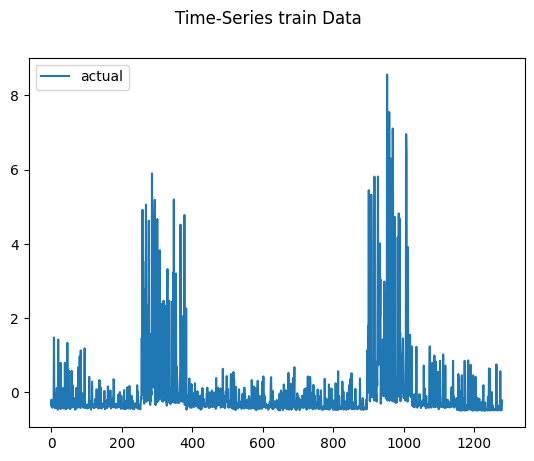

config.json not found in HuggingFace Hub


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 13: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 19: early stopping
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_distributed_input (InputL  [(None, 3, 224, 224  0          []                               
 ayer)                          , 3)]                                                             
                                                                                                  
 lstm_2_input (InputLayer)      [(None, 3, 26)]      0           []                               
                                                                                                  
 sequential (Sequential)        (None, 

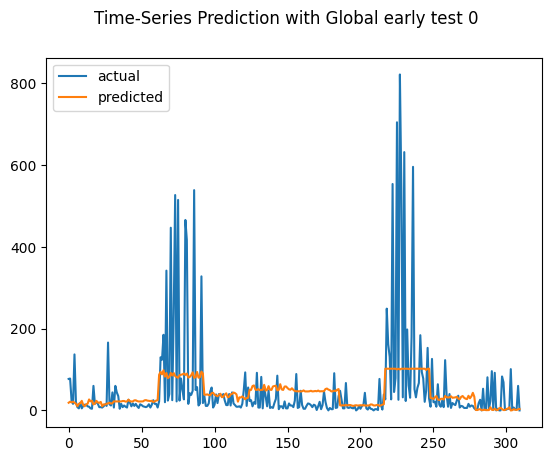

config.json not found in HuggingFace Hub


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 10.
Epoch 18: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 13.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_distributed_2_input (Inpu  [(None, 3, 224, 224  0          []                               
 tLayer)                        , 3)]                                                             
                                                                                                  
 lstm_6_input (InputLayer)      [(None, 3, 26)]      0           []                               
                                                     

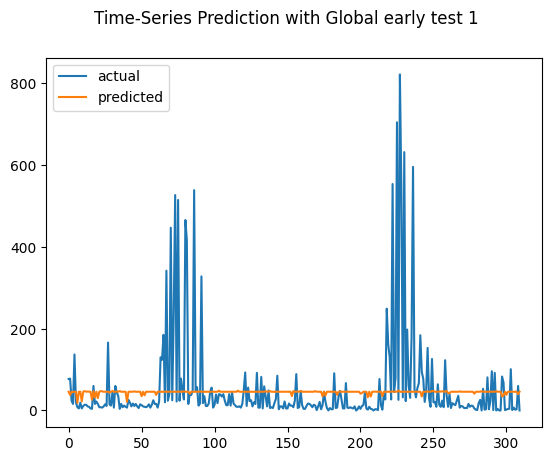

config.json not found in HuggingFace Hub


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 12: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_distributed_4_input (Inpu  [(None, 3, 224, 224  0          []                               
 tLayer)                        , 3)]                                                             
                                                                                                  
 lstm_10_input (InputLayer)     [(None, 3, 26)]      0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None,

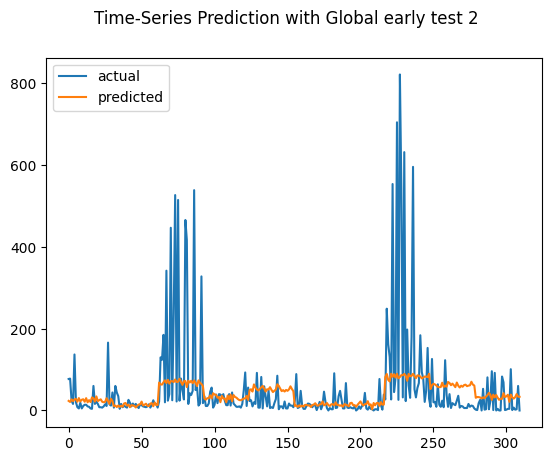

rmse : average=108.450, std=4.342
mae : average=50.031, std=3.254
smape : average=96.608, std=6.267
r2 : average=0.099, std=0.073


([108.45034, 4.342245],
 [50.030666, 3.2543542],
 [96.60753318212365, 6.26662961342606],
 [0.09911162206331477, 0.07274208964345251])

In [18]:
fusion='early'
calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global '+fusion, fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)

# Joint

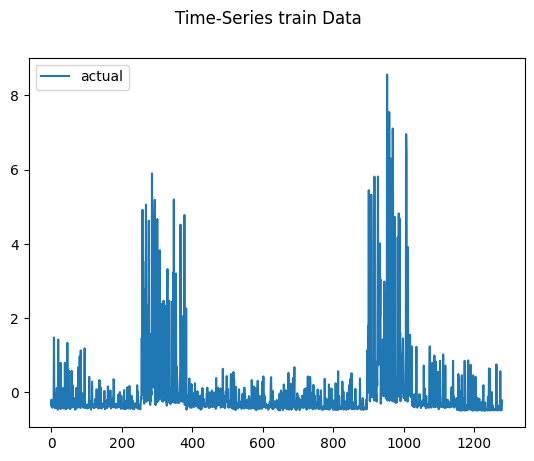

config.json not found in HuggingFace Hub


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_distributed_6_input (Inpu  [(None, 3, 224, 224  0          []                               
 tLayer)                        , 3)]                                                             
                                                                                                  
 lstm_14_input (InputLayer)     [(None, 3, 26)]      0           []                               
                                                                                                  
 sequential_9 (Sequential)      (None, 1)            36923947    ['time_distributed_6_input[0][0]'
                                                                 ]                                
        

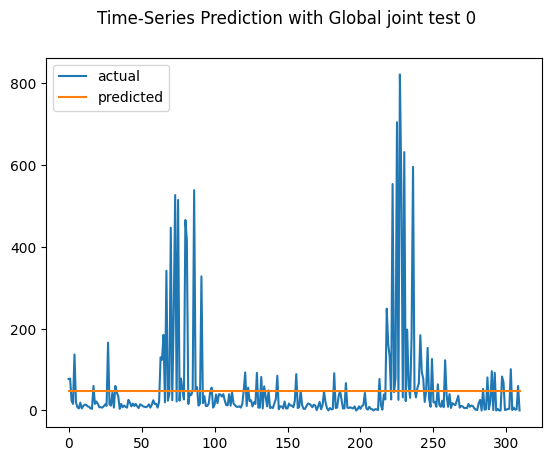

config.json not found in HuggingFace Hub


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_distributed_8_input (Inpu  [(None, 3, 224, 224  0          []                               
 tLayer)                        , 3)]                                                             
                                                                                                  
 lstm_18_input (InputLayer)     [(None, 3, 26)]      0           []                               
                                                                                                  
 sequential_12 (Sequential)     (None, 1)            36923947    ['time_distributed_8_input[0][0]'
                                                                 ]                                
         

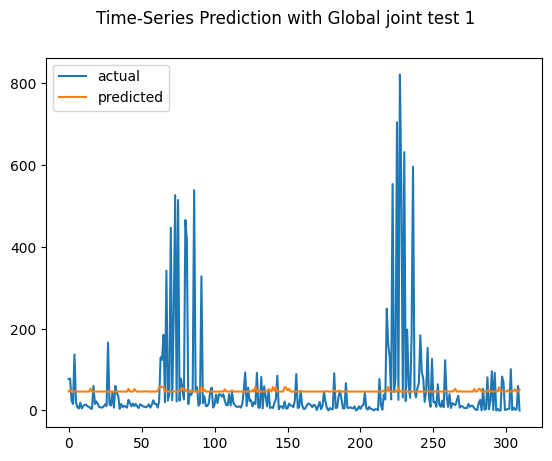

config.json not found in HuggingFace Hub


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Restoring model weights from the end of the best epoch: 6.
Epoch 14: early stopping
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 time_distributed_10_input (Inp  [(None, 3, 224, 224  0          []                               
 utLayer)                       , 3)]                                                             
                                                                                                  
 lstm_22_input (InputLayer)     [(None, 3, 26)]      0           []                               
                                                                                                  
 sequential_15 (Sequential)     (None, 1)            36923947    ['time_distributed_10_input[0][0]
                                                                 ']                               
        

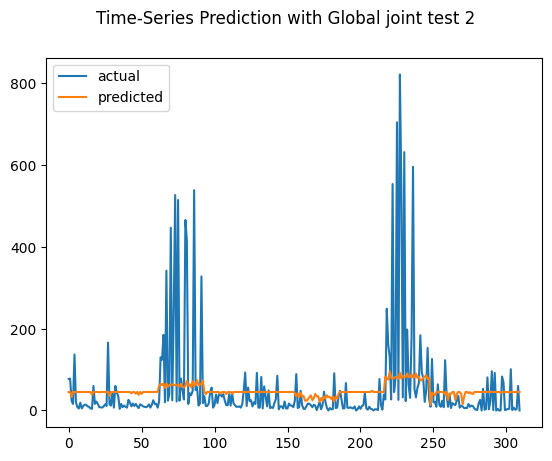

rmse : average=112.327, std=2.921
mae : average=55.187, std=1.697
smape : average=106.252, std=1.975
r2 : average=0.034, std=0.050


([112.32745, 2.921028],
 [55.187145, 1.6972712],
 [106.2521253360215, 1.9754824373725026],
 [0.034440620903494645, 0.04972260056366443])

In [19]:
fusion = 'joint'
calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global '+fusion, fusion=fusion, x_ar=x_ar, x_ar_test=x_ar_test, backbone=backbone, weights=weights, freeze=freeze, projection=projection, learnable_vector=learnable_vector)